# Custom map simulations

In this tutorial we will build a simulation from scratch.

We start by defining a `Band` that will determine our array's sensitivity to different spectra. We then generate an array by specifying a field of view, which will be populated by evenly-spaced beams of the given band.

In [1]:
import maria
from maria.instrument import Band

f090 = Band(center=90, # in GHz
            width=20,
            sensitivity=3e-5) # in K sqrt(s)

f150 = Band(center=150,
            width=30,
            sensitivity=5e-5)

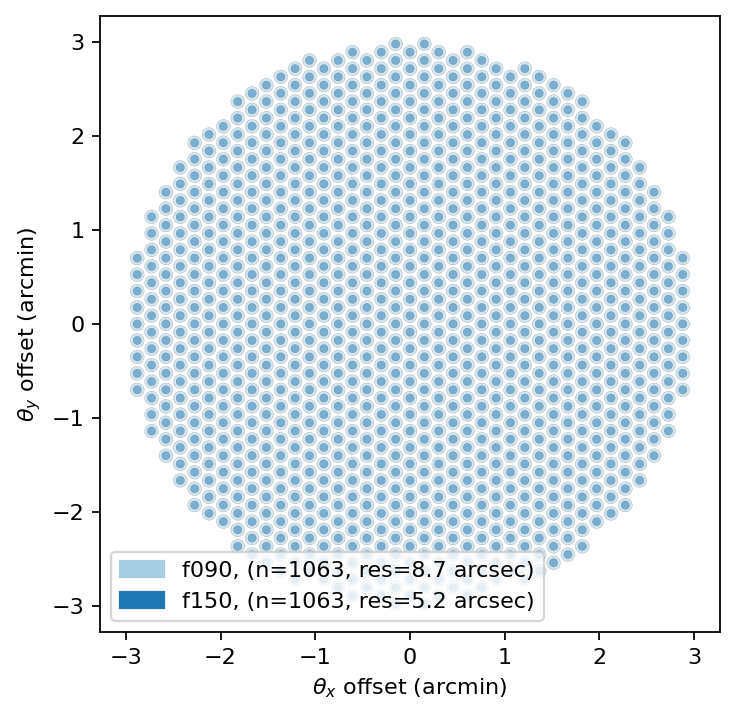

In [2]:
array = {"field_of_view": 0.1, "bands": [f090, f150]}

instrument = maria.get_instrument(array=array, primary_size=100)

instrument.plot()

As something to observe, we can download a map and construct a `map`. We also define a plan to do a daisy scan centered on the center of the map.

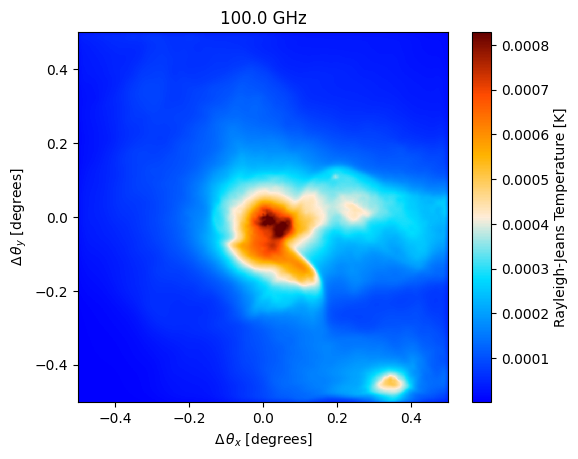

In [3]:
from maria.io import fetch

map_filename = fetch("maps/big_cluster.fits")

input_map = maria.map.read_fits(filename=map_filename, 
                                index=1,
                                width=1, 
                                center=(150, 10), 
                                units="Jy/pixel")

input_map.to(units="K_RJ").plot()

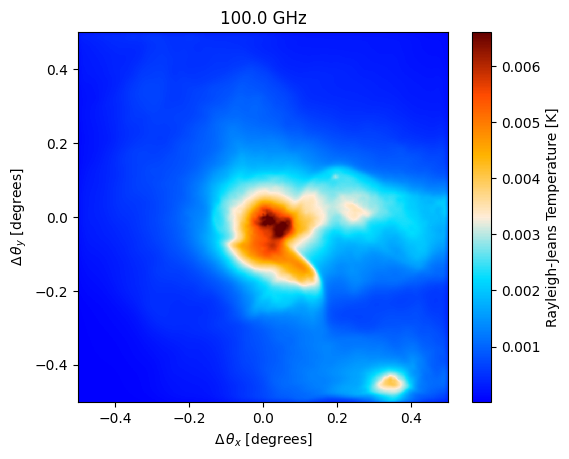

In [12]:
input_map.to(units="K_RJ").plot()

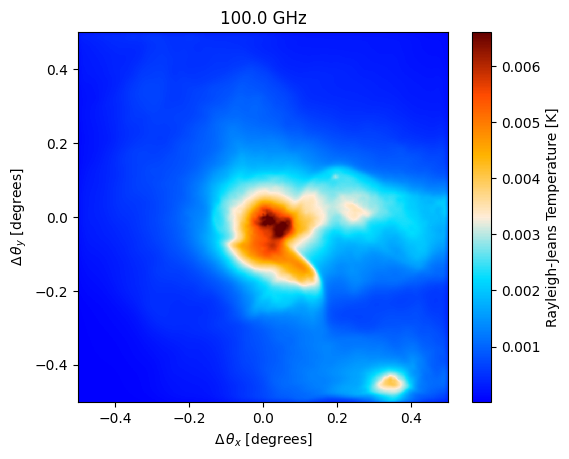

In [13]:
m = input_map.to(units="K_RJ")
m.plot()

In [14]:
import numpy as np

np.degrees(input_map.resolution * 1024)

1.0

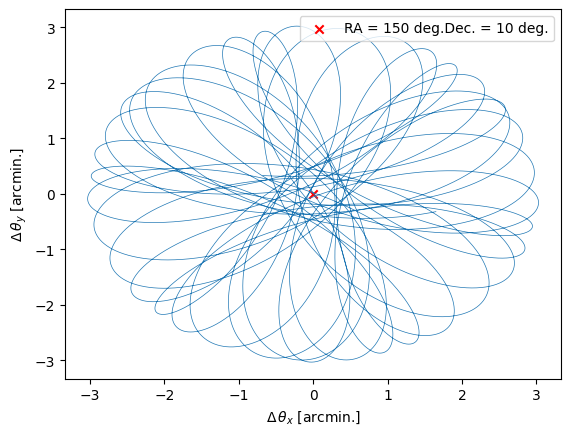

In [15]:
plan = maria.Plan(scan_pattern="daisy",
                  scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                  duration=600, # in seconds
                  sample_rate=50, # in Hz
                  scan_center=(150, 10),
                  frame="ra_dec")

plan.plot()

In [57]:
sim = maria.Simulation(instrument, 
                       plan=plan,
                       site="llano_de_chajnantor", 
                       map=input_map,
                       atmosphere="2d",
                      )

2024-06-19 22:04:33.000 INFO: Constructed instrument.
2024-06-19 22:04:33.009 INFO: Constructed plan.
2024-06-19 22:04:33.011 INFO: Constructed site.
2024-06-19 22:04:33.114 INFO: Constructed boresight.
2024-06-19 22:04:35.964 INFO: Constructed offsets.


Initialized base in 2965 ms.


Initializing atmospheric layers: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.11it/s]


In [58]:
tod = sim.run()

Generating noise: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.66s/it]
Generating atmosphere: 4it [00:08,  2.00s/it]
Sampling map (f150): 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:42<00:00, 21.29s/it]


In [59]:
from maria.map.mappers import BinMapper

mapper = BinMapper(center=(150, 10), 
                   frame="ra_dec", 
                   width=1e-1, 
                   height=1e-1,
                   resolution=4e-4,
                   tod_postprocessing={
                        "window": {"tukey": {"alpha": 0.1}},
                        "remove_modes": {"n": 1},
                        "filter": {"f": 0.08},
                        "despline": {"spacing": 10},
                    },
                    map_postprocessing={
                        "gaussian_filter": {"sigma": 1},
                        "median_filter": {"size": 1},
                    },
                  )

mapper.add_tods(tod)

output_map = mapper.run()

Running mapper (f150): 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:33<00:00, 33.49s/it]


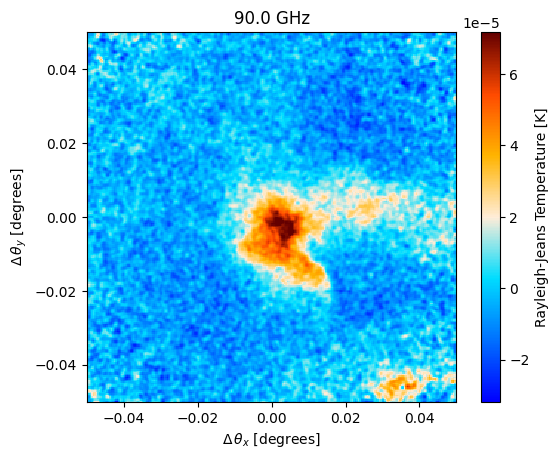

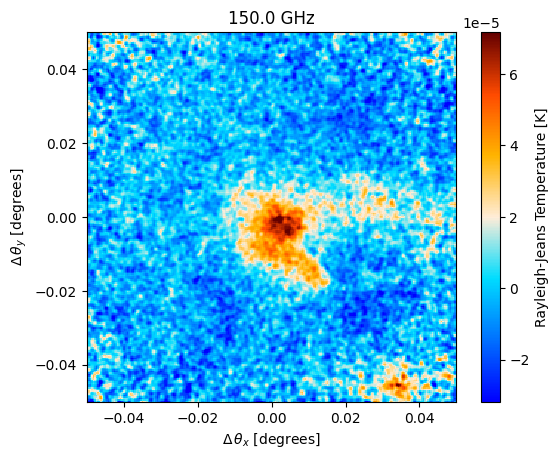

In [60]:
output_map.plot()